In [0]:
import numpy as np
import matplotlib.pyplot as plt
from copy import deepcopy

def euclid_distance(x,y):
  return np.sqrt(np.sum((x-y)**2))

def get_agent_positions(agents,t):
  return np.array([agent.pos[t,:] for agent in agents])

In [0]:
class Agent(object):
  def __init__(self, r_desired, pos, T):
    D = len(pos)
    self.rho = np.zeros([T,2])
    self.mu = np.zeros([T,3])
    #initialize noise variances
    #self.omega_z = np.array([0.1,0.1])
    #self.omega_w = np.array([0.2,0.2])
    self.omega_z = np.array([1,1])
    self.omega_w = np.array([1,1])
    self.gp_noise_var = np.array([0.1,0.1])
    self.z_gp = np.random.normal(0,1,[T,2]) * self.gp_noise_var
    #initialize action 
    self.a = np.zeros([T,D])
    #initialize generative process
    self.pos = np.zeros([T,D])
    self.pos[0,:] = pos #set inital position
    self.vel = np.zeros([T,D])
    self.vel[0,:] = self.a[0,:] #initial velocity is my initial action
    self.avg_dist = np.zeros([T,1]) #initialize average distance from neighbours
    self.dh_partials = np.zeros([T,D]) #partial derivatives of distance functin wrt the D coordinates
    self.d_dot = np.zeros([T,1]) #initialize time derivative of distance function (dh/dx * dx/dt = dh/dt)
    
    self.k = 0.1
    self.ka = 0.1

    self.fe = np.zeros([T,1])
    self.r_desired = r_desired
    self.epsilon_z = np.zeros([T,2])
    self.epsilon_w = np.zeros([T,2])

  def _dhdx(self,my_pos, neighbour_pos):
    """
    Compute partial derivatives of the average position wrt the components 
    """
    dist_vec = my_pos - neighbour_pos
    return dist_vec / np.sqrt(np.sum(dist_vec**2))

  def compute_fe(self, t):
    fe = (1/self.omega_z[0] * (self.epsilon_z[t,0]**2)/2) + ((1/self.omega_z[1]) * (self.epsilon_z[t,1]**2)/2) + ((1/self.omega_w[0])*self.epsilon_w[t,0]**2)/2 + ((1/self.omega_w[1])*self.epsilon_w[t,1]**2)/2 + (0.5 * np.log(np.prod(self.omega_z) *np.prod(self.omega_w)))
    return fe

  def initialize_distances(self, agent_positions):
    N = len(agent_positions) -1
    dh_dout = np.zeros(self.pos.shape[1])
    my_pos = self.pos[0,:]
    avg_dist = 0
    for i in range(len(agent_positions)):
      pos = agent_positions[i,:]
      diff = np.sum(np.abs(pos - my_pos))
      if diff>= 1e-5:
        avg_dist += euclid_distance(my_pos, pos)
        dh_dout += self._dhdx(my_pos, pos)
    self.avg_dist[0,:] = avg_dist / N
    self.dh_partials[0,:] = dh_dout
    self.d_dot[0,:] = np.dot(self.dh_partials[0,:], self.vel[0,:]) # I think this is meant to be a dot product but not sure!
    self.rho[0,:] = np.array([self.avg_dist[0,:],self.d_dot[0,:]]).reshape(2,)
    self.epsilon_z[0,:] = self.rho[0,:] - self.mu[0,0:1]
    self.epsilon_w[0,0] = self.mu[0,1] + self.mu[0,0] - self.r_desired
    self.epsilon_w[0,1] = self.mu[0,2] + self.mu[0,1]
    self.fe[0] = self.compute_fe(0)

  def update_gp(self,agent_positions, t,dt):
    """
    Update the Generative Process -- i.e. the "Real World"
    """
    N = len(agent_positions) -1
    my_prev_pos = deepcopy(self.pos[t,:])
    self.vel[t,:] = deepcopy(self.a[t-1,:])
    self.pos[t,:] = self.pos[t-1,:] + (dt * self.vel[t,:])
    my_pos = deepcopy(self.pos[t,:])
    dh_dout = np.zeros(self.pos.shape[1])
    avg_dist = 0
    for i in range(len(agent_positions)):
      pos = agent_positions[i,:]
      diff = np.sum(np.abs(pos - my_pos))
      if diff >= 1e-5:
        avg_dist += euclid_distance(my_pos, pos)
        dh_dout += self._dhdx(my_pos,pos)
    self.avg_dist[t,:] = avg_dist/N
    self.dh_partials[t,:] = dh_dout
    self.d_dot[t,:] = np.dot(self.dh_partials[t,:], self.vel[t,:])
    self.rho[t,0] = self.avg_dist[t,:] + self.z_gp[t,0] #calculate sensory input for average dist
    self.rho[t,1] = self.d_dot[t,:] + self.z_gp[t,1] # calculate sensory input for time derivative of average dist

  def update_gm(self, t,dt):
    """
    Update the generative model of the agent
    """
    #update error terms
    epsilon_z = self.rho[t-1,:] - self.mu[t-1,0:2]

    print("EZ : ",epsilon_z)
    epsilon_w = np.zeros(2)
    epsilon_w[0] = self.mu[t-1,1] + (self.mu[t-1,0] - self.r_desired)
    epsilon_w[1] = self.mu[t-1,2] + self.mu[t-1,1]
    self.epsilon_z[t,:] = epsilon_z
    self.epsilon_w[t,:] = epsilon_w 
    #calculate VFE
    self.fe[t] = self.compute_fe(t)
    #update mus
    self.mu[t,0] = self.mu[t-1,0] + (dt *(self.mu[t-1,1] - self.k *(-epsilon_z[1]/self.omega_z[1] +epsilon_w[0]/self.omega_w[0])))
    #print("MU: ", self.mu[t,0])
    self.mu[t,1] = self.mu[t-1,1] + (dt * (self.mu[t-1,2] - self.k*(-epsilon_z[1]/self.omega_z[1] + epsilon_w[0]/self.omega_w[0] + epsilon_w[1]/self.omega_w[1])))
    self.mu[t,2] = self.mu[t-1,2] + (dt * -self.k * (epsilon_w[1]/self.omega_w[1]))
    #compute action for active inference
    self.a[t,:] = self.a[t-1,:] + dt * -self.ka * self.dh_partials[t,:]*(epsilon_z[1]/self.omega_z[1])
    #self.a[t,:] /= np.linalg.norm(self.a[t,:])
    #print(self.a[t,:])


Streaming output truncated to the last 5000 lines.
EZ :  [ 0.35445594 -0.05369772]
MU:  0.9968522053343657
[ 0.00252836 -0.00166761  0.0002427 ]
EZ :  [ 1.55880551 -0.06839157]
MU:  0.9941670941536181
[-0.00299294  0.00184888  0.00194155]
EZ :  [ 1.09830967 -0.10368798]
MU:  0.9983105958443989
[ 0.00586124  0.00335771 -0.0069505 ]
EZ :  [ 0.52145239 -0.14770889]
MU:  0.9800066283592178
[ 0.0107028  -0.01094911  0.01288139]
EZ :  [0.916973   0.04060436]
MU:  0.9933679331218721
[-0.00350948 -0.00546876  0.00267571]
EZ :  [0.99558724 0.02338171]
MU:  0.9943466289498357
[ 0.00147308 -0.00395103  0.00142462]
EZ :  [0.77631949 0.02823865]
MU:  0.9932127532774352
[ 0.00014481 -0.00374535  0.00085058]
EZ :  [ 0.59035874 -0.04154092]
MU:  0.9967711523775249
[-0.00652232 -0.01060385 -0.00333313]
EZ :  [ 0.91360257 -0.10255244]
MU:  0.9959847789552957
[ 0.00134847 -0.00722467  0.00371364]
EZ :  [1.34452311 0.05955785]
MU:  0.9964205848528637
[-3.56652787e-05  1.04869360e-02  1.41893491e-04]
EZ : 

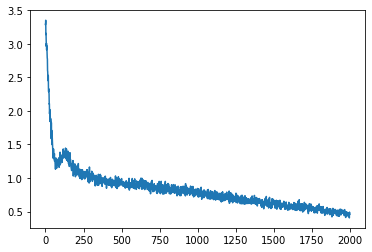

In [414]:

N = 10
D = 3
sim_time = 200
dt  = 0.1
time_axis = np.linspace(0,sim_time, int(sim_time//dt))
T = len(time_axis)
r_desired =1
r_desired_vec = r_desired * np.ones([N,1])
init_pos = np.random.normal(0,1,size=[N,D])
agents = []
for i in range(N):
  agent = Agent(r_desired_vec[i],init_pos[i,:],T)
  agent.initialize_distances(init_pos)
  agents.append(agent)

for t in range(1,T):
  agent_positions = get_agent_positions(agents, t-1)
  for agent in agents:
    agent.update_gp(agent_positions, t,dt)
    agent.update_gm(t,dt)

  
all_positions = np.zeros([T,D,N])
all_velocities = np.zeros(all_positions.shape)
all_fe = np.zeros([T,N])
for i in range(N):
  all_positions[:,:,i] = agents[i].pos
  all_velocities[:,:,i] = agents[i].vel
  all_fe[:,i] = agents[i].fe.reshape(T,)

#print(all_fe[:,0])

print("FE: ", all_fe)
plt.plot(np.mean(all_fe,axis=1))
plt.show()



